In [1]:
import pandas as pd
import numpy as np
# load the provided data
train_df = pd.read_csv('data/processed_train_data_lag2.csv')
test_df = pd.read_csv('data/processed_test_data_lag2.csv')

In [2]:
print(train_df.shape)
print(test_df.shape)

(1456, 14)
(416, 13)


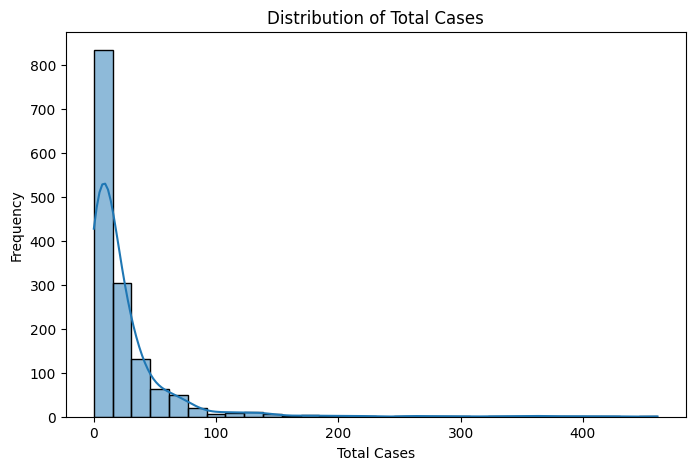

reanalysis_min_air_temp_k_lag2                0.342015
reanalysis_min_air_temp_k                     0.324776
reanalysis_air_temp_k_lag2                    0.295637
city                                          0.292624
reanalysis_air_temp_k                         0.264564
weekofyear                                    0.216452
reanalysis_specific_humidity_g_per_kg_lag2    0.162501
reanalysis_specific_humidity_g_per_kg         0.129671
station_precip_mm_lag2                       -0.068399
station_precip_mm                            -0.076173
Name: total_cases, dtype: float64

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 繪製 total_cases 分佈
plt.figure(figsize=(8,5))
sns.histplot(train_df['total_cases'], bins=30, kde=True)
plt.title('Distribution of Total Cases')
plt.xlabel('Total Cases')
plt.ylabel('Frequency')
plt.show()

# 計算特徵與 total_cases 的相關性
correlation_matrix = train_df.corr()
correlation_with_cases = correlation_matrix["total_cases"].sort_values(ascending=False)

# 顯示相關性最高的前10個特徵
top_correlated_features = correlation_with_cases.iloc[1:11]  # 排除 total_cases 自身
top_correlated_features


In [34]:
#train_df["total_cases"] = np.log1p(train_df["total_cases"])

In [35]:
# # 進行特徵工程
# def feature_exchange(df):
#     # 1. 週期特徵轉換
#     df["sin_week"] = np.sin(2 * np.pi * df["weekofyear"] / 52)
#     df["cos_week"] = np.cos(2 * np.pi * df["weekofyear"] / 52)
    
#     # 3. 移動平均特徵
#     df["temp_ma4"] = df["reanalysis_air_temp_k"].rolling(window=4, min_periods=1).mean()
#     df["humidity_ma4"] = df["reanalysis_specific_humidity_g_per_kg"].rolling(window=4, min_periods=1).mean()
    
#     return df
# train_df = feature_exchange(train_df)
# test_df = feature_exchange(test_df)

In [36]:
# 圣胡安数据分离
train_df_sj = train_df[train_df['city'] == 1]
train_df_iq = train_df[train_df['city'] == 0]
test_df_sj = test_df[test_df['city'] == 1]
test_df_iq = test_df[test_df['city'] == 0]

In [37]:
train_df_sj.drop(['city'], axis=1, inplace=True)
train_df_iq.drop(['city'], axis=1, inplace=True)
test_df_sj.drop(['city'], axis=1, inplace=True)
test_df_iq.drop(['city'], axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24068\3331971527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_sj.drop(['city'], axis=1, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24068\3331971527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_iq.drop(['city'], axis=1, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24068\3331971527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [138]:
#檢查平穩性
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(train_df_sj['total_cases'])


ADF Statistic: -6.6500779019311915
p-value: 5.147318673759216e-09
Stationary


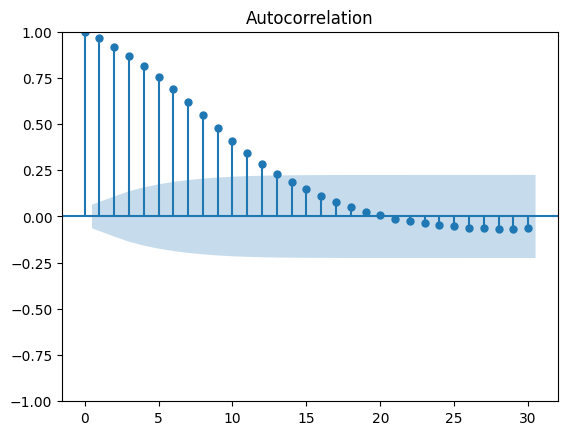

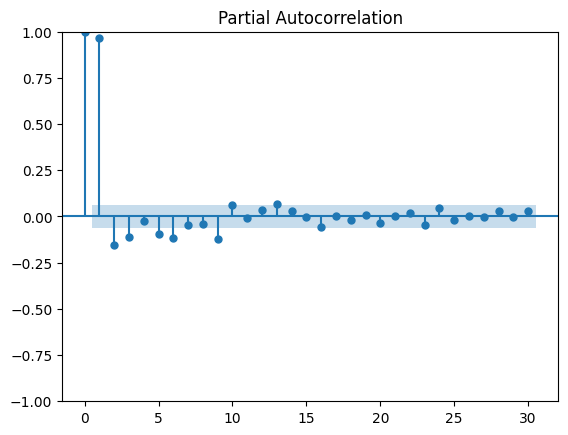

In [139]:
# Plot ACF and PACF
plot_acf(train_df_sj['total_cases'])
plot_pacf(train_df_sj['total_cases'])
plt.show()


In [140]:
# Define SARIMA parameters
p, d, q = 4, 1, 12
P, D, Q, s = 1, 1, 0, 100  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(train_df_sj['total_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model


D:\anaconda\envs\NLP\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_len = len(test_df_sj)

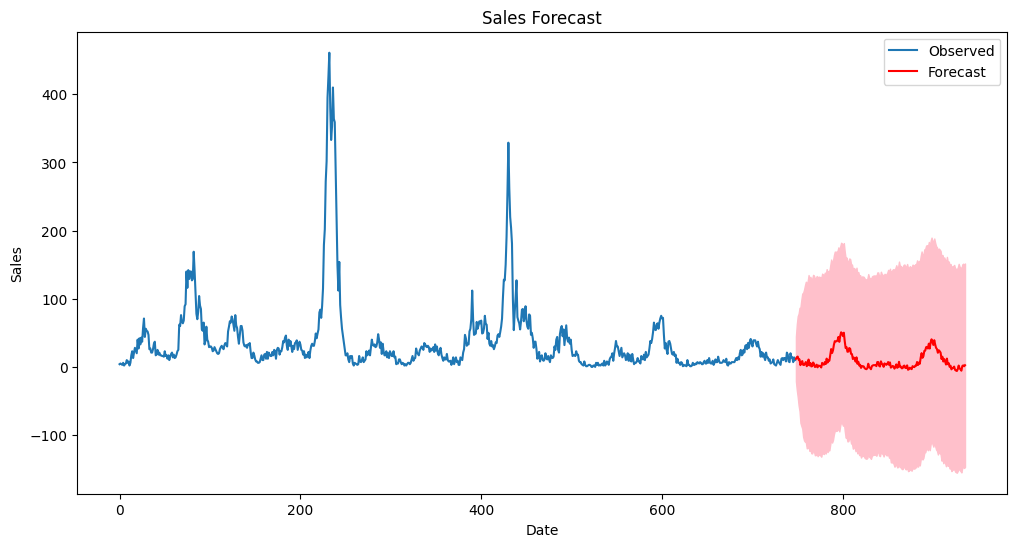

In [100]:
# Forecast future values
forecast_periods = forecast_len  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_df_sj['total_cases'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [113]:
# observed = test_data_sj['total_cases'][-forecast_periods:] 
# mae = mean_absolute_error(observed, forecast_mean_sj+9)
# mse = mean_squared_error(observed, forecast_mean_sj)
# print(f'MAE: {mae}')
# print(f'MSE: {mse}')

MAE: 12.490101743786287
MSE: 716.0449044270231


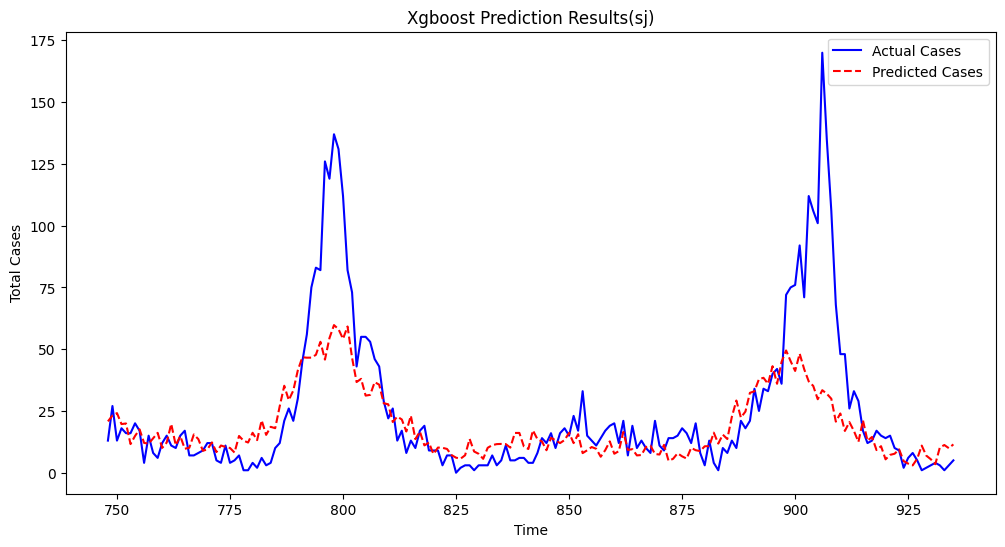

In [114]:
# 視覺化預測結果
plt.figure(figsize=(12, 6))
plt.plot(forecast_mean_sj+9, label="Predicted Cases", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("SARIMA Prediction Results(sj)")
plt.legend()
plt.show()

In [124]:
#檢查平穩性
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(train_df_iq['total_cases'])


ADF Statistic: -5.059884794706833
p-value: 1.687049621527151e-05
Stationary


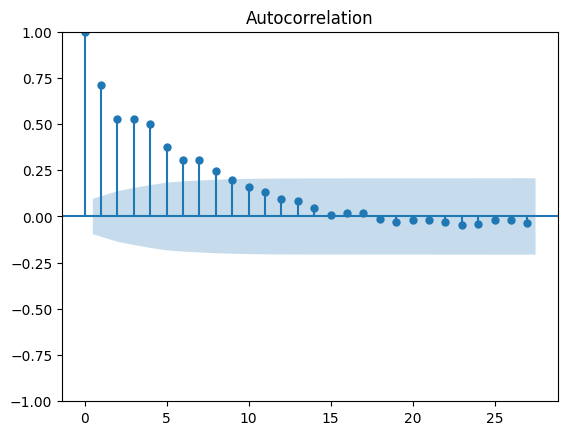

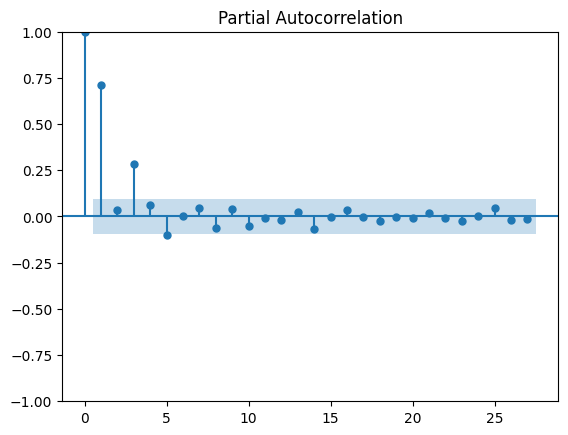

In [125]:
# Plot ACF and PACF
plot_acf(train_df_iq['total_cases'])
plot_pacf(train_df_iq['total_cases'])
plt.show()


In [ ]:
forecast_len = len(test_df_iq)

In [135]:
# Define SARIMA parameters
p, d, q = 3, 1, 12
P, D, Q, s = 1, 1, 0, 100  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(train_df_iq['total_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
# Forecast future values
forecast_periods = forecast_len  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()



D:\anaconda\envs\NLP\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\anaconda\envs\NLP\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\anaconda\envs\NLP\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\anaconda\envs\NLP\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

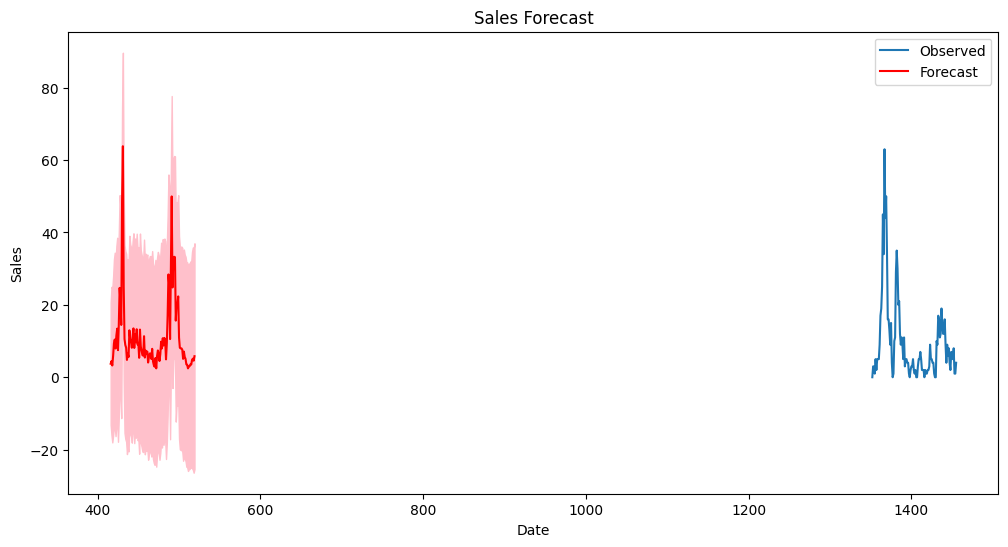

MAE: 7.821028802749045
MSE: 140.7393712433648


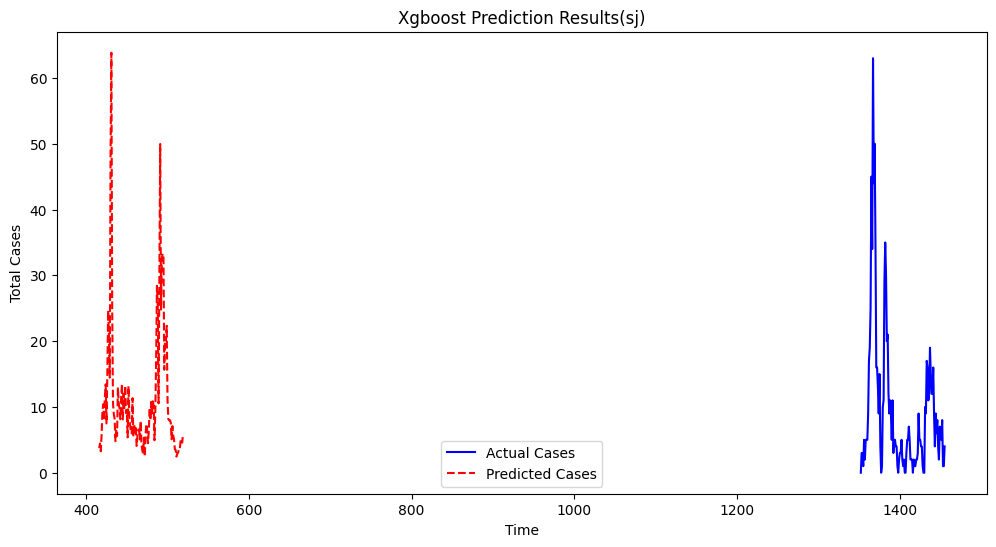

In [137]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df_iq['total_cases'], label='Observed')
plt.plot(forecast_mean_iq, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

observed = test_df_iq['total_cases'][-forecast_periods:] 
# mae = mean_absolute_error(observed, forecast_mean_iq)
# mse = mean_squared_error(observed, forecast_mean_iq)
# print(f'MAE: {mae}')
# print(f'MSE: {mse}')

# 視覺化預測結果
plt.figure(figsize=(12, 6))
#plt.plot(observed, label="Actual Cases", color='blue')
plt.plot(forecast_mean, label="Predicted Cases", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Xgboost Prediction Results(sj)")
plt.legend()
plt.show()